In this notebook, let's consider all the functionalities of langchain under the lense of how to be a more productive researcher.

# Leveraging Code Execution

In [1]:
%pip install -qU langchain
%pip install langchain-core
%pip install langchain-community
%pip install langchain-experimental
%pip install langchain-openai
%pip install duckduckgo-search
%pip install xmltodict

In [2]:
import os
import getpass

# Set OPENAI API Key

import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

True

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate    
from langchain.schema.output_parser import StrOutputParser
from langchain_experimental.utilities import PythonREPL

In [2]:
template = """Write some python code to solve the user's problem. 

Return only python code in Markdown format, e.g.:

```python
....
```"""
prompt = ChatPromptTemplate.from_messages([("system", template), ("human", "{input}")])

model = ChatOpenAI(model='gpt-4o-mini')

In [3]:
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0]

In [4]:
chain = prompt | model | StrOutputParser() | _sanitize_output | PythonREPL().run

In [5]:
chain.invoke({"input": "whats 2 plus 2"})

Python REPL can execute arbitrary code. Use with caution.


'4\n'

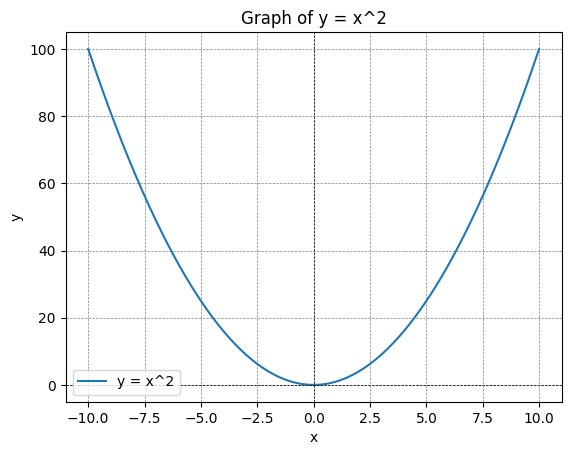

''

In [6]:
chain.invoke({"input": "Plot a graph of x squared"})

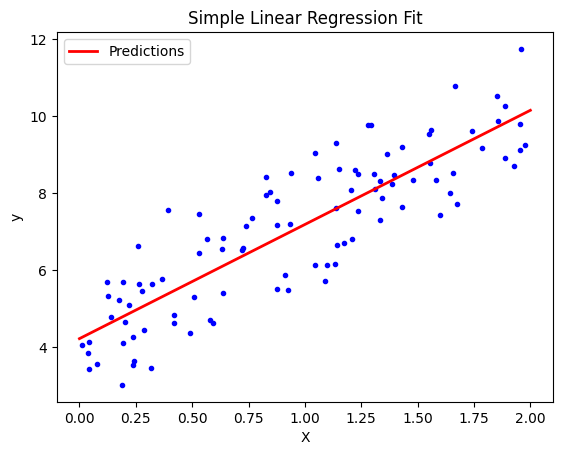

''

In [7]:
chain.invoke({"input": "Plot a simple linear regression fit over some toy example data, use numpy and not sklearn"})

# Automating Literature Review with LangChain

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [9]:
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain_openai import ChatOpenAI

tools = load_tools(
    ["arxiv"],
)
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [10]:
agent_executor.invoke(
    {
        "input": "Latest top 3 papers about Large Language Models",
    }
)



> Entering new AgentExecutor chain...
I need to find the latest research papers related to Large Language Models. I'll search for recent papers on arXiv that focus on this topic. 
Action: arxiv
Action Input: "Large Language Models" Published: 2023-06-12
Title: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Summary: In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa,
Google's PaLM) have become the dominant approach for building AI systems to
analyze and generate language online. However, the automated systems that
increasingly mediate our interactions online -- such as chatbots, content
moderation systems, and search engines -- are primarily designed for and work
far more effectively in English than in the world's other 7,000 languages.
Recently, researchers and technology companies have attempted to extend the
capabilities of large language models into languages other than English by
building

{'input': 'Latest top 3 papers about Large Language Models',
 'output': 'The latest top 3 papers about Large Language Models are:\n1. "Lost in Translation: Large Language Models in Non-English Content Analysis" (2023-06-12)\n2. "How Good are Commercial Large Language Models on African Languages?" (2023-05-11)\n3. "Cedille: A large autoregressive French language model" (2022-02-07)'}

To automate literature review with Langchain, you can use the PubMedRetriever and PubMedLoader modules. Here's how you can do it:

• Install the required packages:

In [11]:
# Import the necessary modules:
from langchain.retrievers import PubMedRetriever #for the PubMedRetriever module.
from langchain.document_loaders import PubMedLoader #for the PubMedLoader module.

In [12]:
#• Create an instance of the PubMedRetriever:

retriever = PubMedRetriever()

In [14]:
# Use the PubMedRetriever to get relevant documents based on a search query:
query = "neuroplasticity"
docs = retriever.invoke(query)
docs

HTTPError: HTTP Error 400: Bad Request

In [15]:

# • Create an instance of the PubMedLoader:

loader = PubMedLoader(query)

# Load the documents using the PubMedLoader:

docs = loader.load()

In [16]:
# You can now access the loaded documents and their metadata:

docs #to access the metadata of the first document.

[Document(metadata={'uid': '39396893', 'Title': 'Characterizing visual processing deficits in cerebral adrenoleukodystrophy.', 'Published': '2024-10-12', 'Copyright Information': 'Copyright © 2024. Published by Elsevier B.V.'}, page_content='BACKGROUND AND OBJECTIVES: Cerebral adrenoleukodystrophy (CALD) can cause visual impairment, but early symptoms are often missed or misdiagnosed. The framework of cerebral visual impairment (CVI) distinguishes deficits in sensory detection ("lower order") from those of perception and interpretation ("higher order"). This study describes visual deficits in patients with CALD and higher order visual function assessed with a virtual reality (VR) interface combined with eye tracking.\nMETHODS: A retrospective medical record review assessed the prevalence of visual deficits in patients with CALD, as well as lesion burden on brain MRI using the Loes MRI severity score. A VR-based task measured visual spatial processing performance in participants with CA

In [17]:
docs[0].page_content #to access the content of the first document.

#By using the PubMedRetriever and PubMedLoader modules, you can automate the process of retrieving and loading relevant literature for your literature review.

'BACKGROUND AND OBJECTIVES: Cerebral adrenoleukodystrophy (CALD) can cause visual impairment, but early symptoms are often missed or misdiagnosed. The framework of cerebral visual impairment (CVI) distinguishes deficits in sensory detection ("lower order") from those of perception and interpretation ("higher order"). This study describes visual deficits in patients with CALD and higher order visual function assessed with a virtual reality (VR) interface combined with eye tracking.\nMETHODS: A retrospective medical record review assessed the prevalence of visual deficits in patients with CALD, as well as lesion burden on brain MRI using the Loes MRI severity score. A VR-based task measured visual spatial processing performance in participants with CALD and controls.\nRESULTS: Out of 89 CALD patients, 69\xa0% had at least one sign or symptom of visual impairment. Lower order deficits were seen in 56\xa0% of patients, and higher order deficits were seen in 59\xa0% of patients who underwen

In [18]:
len(docs)

3

In [19]:
from langchain_community.tools.pubmed.tool import PubmedQueryRun

In [20]:
tool = PubmedQueryRun()

In [21]:
tool.invoke("chatgpt")

"Published: 2024-10-14\nTitle: AI-generated vs. student-crafted assignments and implications for evaluating student work in nursing: an exploratory reflection.\nCopyright Information: © 2024 Walter de Gruyter GmbH, Berlin/Boston.\nSummary::\nOBJECTIVES: Chat Generative Pre-Trained Transformer (ChatGPT) is an artificial intelligence-powered language model that can generate a unique outputs, in reponse to a user's textual request. This has raised concerns related to academic integrity in nursing education as students may use the platform to generate original assignment content. Subsequently, the objective of this quality improvement project were to explore and identify effective strategies that educators can use to discern AI-generated papers from student-written submissions.\nMETHODS: Four nursing students were requested to submit two versions a Letter to the Editor assignement; one assignment that was written by the student; the other, exclusively generated by ChatGPT-3.5.\nRESULTS: AI

With duck duck go search

In [22]:
import requests
from bs4 import BeautifulSoup
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.openai_functions.extraction import create_extraction_chain_pydantic
from langchain.agents import load_tools, AgentExecutor
import pandas as pd

In [23]:
def parse_html(content):
    soup = BeautifulSoup(content, 'html.parser')
    text_content_with_links = soup.get_text()
    return text_content_with_links

def fetch_web_page(url):
    response = requests.get(url)
    return parse_html(response.content)

In [24]:
tools = load_tools(["arxiv"])
prompt = hub.pull("hwchase17/react")
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [25]:
output = agent_executor.invoke({"input": "Research 3 papers about large language models"})



> Entering new AgentExecutor chain...
I need to find recent research papers that focus on large language models. I'll search for relevant papers on arXiv to gather information on this topic.  
Action: arxiv  
Action Input: "large language models"  Published: 2023-06-12
Title: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Summary: In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa,
Google's PaLM) have become the dominant approach for building AI systems to
analyze and generate language online. However, the automated systems that
increasingly mediate our interactions online -- such as chatbots, content
moderation systems, and search engines -- are primarily designed for and work
far more effectively in English than in the world's other 7,000 languages.
Recently, researchers and technology companies have attempted to extend the
capabilities of large language models into languages other than Eng

In [26]:
output

{'input': 'Research 3 papers about large language models',
 'output': '1. **Lost in Translation: Large Language Models in Non-English Content Analysis**  \n   - Authors: Gabriel Nicholas, Aliya Bhatia  \n   - Summary: This paper discusses the limitations of large language models in non-English languages and explores multilingual language models, providing recommendations for their development and deployment.\n\n2. **Cedille: A large autoregressive French language model**  \n   - Authors: Martin Müller, Florian Laurent  \n   - Summary: The paper introduces Cedille, a large autoregressive language model specifically for French, demonstrating its competitive performance against existing models and improvements in safety.\n\n3. **How Good are Commercial Large Language Models on African Languages?**  \n   - Authors: Jessica Ojo, Kelechi Ogueji  \n   - Summary: This research analyzes the performance of commercial large language models on African languages, revealing subpar results and emphas

In [27]:
# Define a Pydantic schema for your data (modify according to your data structure)
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class LiteratureData(BaseModel):
    """Extracts paper information from the output of an arxiv search."""
    titles: List[str] = Field(description='The titles of the papers referenced in the search result')
    abstracts: List[str] = Field(description='The abstracts of the papers referenced in the search result')
    citations: List[str] = Field(description='The citations of the papers referenced in the search result')
    

prompt = ChatPromptTemplate.from_messages([
    ('system', """
                You are an extraction engine for papers. You extract the following fields:
                - title
                - abstract
                - citation
                When users feed you data from papers, you extract these fields."""),
    ('user', '{input}')])

extraction_chain = prompt | llm.with_structured_output(LiteratureData)
extraction_chain

/Users/greatmaster/miniconda3/envs/oreilly-langchain/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


ChatPromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\n                You are an extraction engine for papers. You extract the following fields:\n                - title\n                - abstract\n                - citation\n                When users feed you data from papers, you extract these fields.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={})])
| RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x10dcd7490>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x1281a5410>, root_client=<openai.OpenAI object at 0x11fdc1150>, root_async_client=<openai.AsyncOpenAI object at 0x1281def50>, model_name='gpt-4o-mini', tempera

In [28]:
output_structured = extraction_chain.invoke(output['output'])
output_structured

LiteratureData(titles=['Lost in Translation: Large Language Models in Non-English Content Analysis', 'Cedille: A large autoregressive French language model', 'How Good are Commercial Large Language Models on African Languages?'], abstracts=['This paper discusses the limitations of large language models in non-English languages and explores multilingual language models, providing recommendations for their development and deployment.', 'The paper introduces Cedille, a large autoregressive language model specifically for French, demonstrating its competitive performance against existing models and improvements in safety.', 'This research analyzes the performance of commercial large language models on African languages, revealing subpar results and emphasizing the need for better representation of these languages in such models.'], citations=['Gabriel Nicholas, Aliya Bhatia', 'Martin Müller, Florian Laurent', 'Jessica Ojo, Kelechi Ogueji'])

In [29]:
import pandas as pd

# Create a dictionary with the lists as values

data = {
    "title": output_structured.titles,
    "abstract": output_structured.abstracts,
    "citation": output_structured.citations
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,title,abstract,citation
0,Lost in Translation: Large Language Models in ...,This paper discusses the limitations of large ...,"Gabriel Nicholas, Aliya Bhatia"
1,Cedille: A large autoregressive French languag...,"The paper introduces Cedille, a large autoregr...","Martin Müller, Florian Laurent"
2,How Good are Commercial Large Language Models ...,This research analyzes the performance of comm...,"Jessica Ojo, Kelechi Ogueji"
